## 1) Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from datetime import datetime

## 2) Read dataset

In [2]:
df = pd.read_csv("dataset/dataset_SCL.csv")

/tmp/ipykernel_24034/2296791871.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset/dataset_SCL.csv")


In [3]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [4]:
def calculate_missing_values(df):
    '''Receive a dataframe and calculate the percentage of missing values'''

    # Step 1: Calculate the total number of missing values per column
    missing_values = df.isnull().sum()

    # Step 2: Calculate the total number of rows in the DataFrame
    total_rows = df.shape[0]

    # Step 3: Calculate the percentage of missing values per column
    percentage_missing = (missing_values / total_rows) * 100

    # Step 4: Create a new DataFrame to display the results
    result_df = pd.DataFrame({
        'Column': missing_values.index,
        'Percentage Missing': percentage_missing
    })

    # Step 5: Print the result DataFrame
    print(result_df)

#_______________________________________________________________________________________

def plot_bar_categorical_features(df,column_name):
    '''Plot bar plot of categorical feature using percetange in the Y axis
    given the dataframe df and the column_name'''

    available_status = df[column_name].value_counts()
    plt.figure(figsize=(10,6))
    (available_status/df.shape[0]).plot(kind="bar");
    plt.title("Perc distribution - "+column_name);
    plt.show()


## 3) Challenge questions

### 3.1) How is the data distributed? Did you find any noteworthy insight to share? What can you conclude about this?

**Answer:**
- The busiest months of the year are January/February and December;
- The end of the month are the busiest period of the month;
- The following columns have all the same registers for every row:
    - AÑO (Year of flight operation.): 2017
    - SIGLAORI (Name city of origin.): Santiago
    - Ori-O (Operation origin city code): SCEL
- There are more national flights than international, however the distribution is very similar;
- Grupo Latam airlines operates around 60% of the flights
- There were 0.15% of the flights that had different flight scheduled number from operation flight number;
- The airline code (Emp-I) correspond to airline name (OPERA);
- The columns Ori-I (Programmed origin city code.) and Ori-O (Operation origin city code) are the same; It means that the flight plans towards the city did not change but related to the flight can change;
- About the weekdays:
    - Friday is the busiest weekday;
    - Friday, Thursday, Monday have very similar flight numbers;
    - Sunday, Wednesdays, Tuesday have very similar flight numbers;
    - Saturday is the less busy day; 
- Columns that I can drop before training a model: AÑO, SIGLAORI, Ori-O, Ori-I, Emp-I.

**Analysis ideas ideas**
- Check distribution of national and international flights
- Check if there is a python library for destination city code for airports
- Check if national and international flights change accoridng the the weekday
- Check if flights distributed in days of the week change accoring to the months

**Check Nan values**

In [5]:
#Evaluate percentage of missing values
print("df.shape = ", df.shape)
calculate_missing_values(df)

df.shape =  (68206, 18)
              Column  Percentage Missing
Fecha-I      Fecha-I            0.000000
Vlo-I          Vlo-I            0.000000
Ori-I          Ori-I            0.000000
Des-I          Des-I            0.000000
Emp-I          Emp-I            0.000000
Fecha-O      Fecha-O            0.000000
Vlo-O          Vlo-O            0.001466
Ori-O          Ori-O            0.000000
Des-O          Des-O            0.000000
Emp-O          Emp-O            0.000000
DIA              DIA            0.000000
MES              MES            0.000000
AÑO              AÑO            0.000000
DIANOM        DIANOM            0.000000
TIPOVUELO  TIPOVUELO            0.000000
OPERA          OPERA            0.000000
SIGLAORI    SIGLAORI            0.000000
SIGLADES    SIGLADES            0.000000


In [6]:
#Drop rows with missing values
df.dropna(inplace=True)

#Verify dataframe after dropping rows with Nan values
print("df.shape = ", df.shape)
calculate_missing_values(df)

df.shape =  (68205, 18)
              Column  Percentage Missing
Fecha-I      Fecha-I                 0.0
Vlo-I          Vlo-I                 0.0
Ori-I          Ori-I                 0.0
Des-I          Des-I                 0.0
Emp-I          Emp-I                 0.0
Fecha-O      Fecha-O                 0.0
Vlo-O          Vlo-O                 0.0
Ori-O          Ori-O                 0.0
Des-O          Des-O                 0.0
Emp-O          Emp-O                 0.0
DIA              DIA                 0.0
MES              MES                 0.0
AÑO              AÑO                 0.0
DIANOM        DIANOM                 0.0
TIPOVUELO  TIPOVUELO                 0.0
OPERA          OPERA                 0.0
SIGLAORI    SIGLAORI                 0.0
SIGLADES    SIGLADES                 0.0


**Evaluate numerical features**

In [7]:
#Convert Vlo-O and Vlo-I to int type - Part 1

# Step 1: Use pd.to_numeric() to convert the column to numeric type
df['Vlo-O'] = pd.to_numeric(df['Vlo-O'], errors='coerce')
df['Vlo-I'] = pd.to_numeric(df['Vlo-I'], errors='coerce')

calculate_missing_values(df)

              Column  Percentage Missing
Fecha-I      Fecha-I            0.000000
Vlo-I          Vlo-I            0.007331
Ori-I          Ori-I            0.000000
Des-I          Des-I            0.000000
Emp-I          Emp-I            0.000000
Fecha-O      Fecha-O            0.000000
Vlo-O          Vlo-O            0.023459
Ori-O          Ori-O            0.000000
Des-O          Des-O            0.000000
Emp-O          Emp-O            0.000000
DIA              DIA            0.000000
MES              MES            0.000000
AÑO              AÑO            0.000000
DIANOM        DIANOM            0.000000
TIPOVUELO  TIPOVUELO            0.000000
OPERA          OPERA            0.000000
SIGLAORI    SIGLAORI            0.000000
SIGLADES    SIGLADES            0.000000


In [8]:
#Convert Vlo-O and Vlo-I to int type - Part 2

#Drop rows with missing values
df.dropna(inplace=True)

#Verify dataframe after dropping rows with Nan values
print("df.shape = ", df.shape)
calculate_missing_values(df)

# Step 2: Use astype() to convert the column to integer type
df['Vlo-O'] = df['Vlo-O'].astype(int)
df['Vlo-I'] = df['Vlo-I'].astype(int)

df.shape =  (68185, 18)
              Column  Percentage Missing
Fecha-I      Fecha-I                 0.0
Vlo-I          Vlo-I                 0.0
Ori-I          Ori-I                 0.0
Des-I          Des-I                 0.0
Emp-I          Emp-I                 0.0
Fecha-O      Fecha-O                 0.0
Vlo-O          Vlo-O                 0.0
Ori-O          Ori-O                 0.0
Des-O          Des-O                 0.0
Emp-O          Emp-O                 0.0
DIA              DIA                 0.0
MES              MES                 0.0
AÑO              AÑO                 0.0
DIANOM        DIANOM                 0.0
TIPOVUELO  TIPOVUELO                 0.0
OPERA          OPERA                 0.0
SIGLAORI    SIGLAORI                 0.0
SIGLADES    SIGLADES                 0.0


In [9]:
print(df.dtypes)

Fecha-I      object
Vlo-I         int64
Ori-I        object
Des-I        object
Emp-I        object
Fecha-O      object
Vlo-O         int64
Ori-O        object
Des-O        object
Emp-O        object
DIA           int64
MES           int64
AÑO           int64
DIANOM       object
TIPOVUELO    object
OPERA        object
SIGLAORI     object
SIGLADES     object
dtype: object


array([[<Axes: title={'center': 'Vlo-I'}>,
        <Axes: title={'center': 'Vlo-O'}>],
       [<Axes: title={'center': 'DIA'}>, <Axes: title={'center': 'MES'}>],
       [<Axes: title={'center': 'AÑO'}>, <Axes: >]], dtype=object)

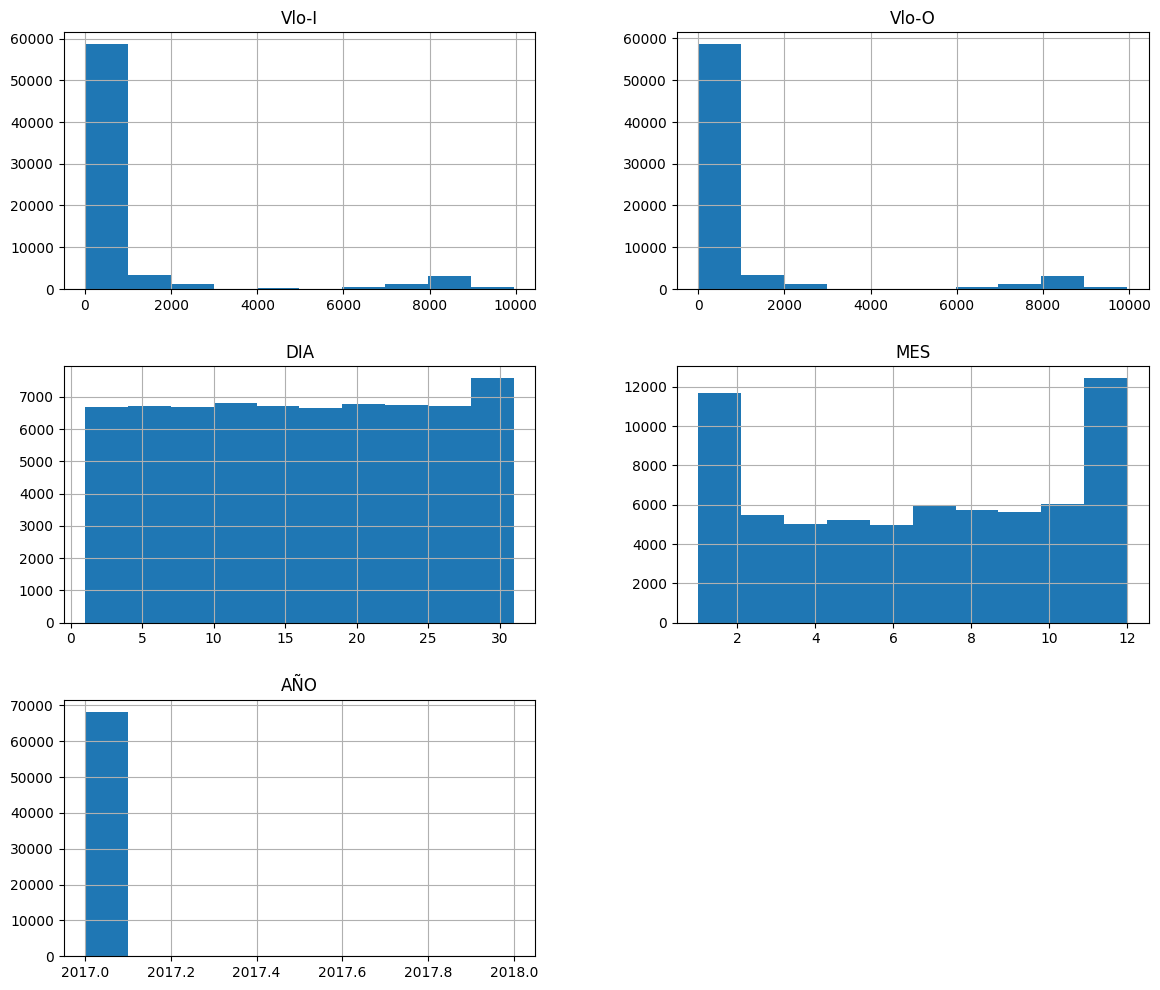

In [10]:
df.hist(figsize = (14,12))

In [11]:
# The distribution of Vlo-O and Vlo-I look the same. Are these two columns equal?
df['Vlo-O'].equals(df['Vlo-I']) 

False

In [12]:
# Are the columns Ori-I and Ori-O equal?
df['Ori-I'].equals(df['Ori-O']) 

True

In [13]:
# using Counter to find frequency of elements
frequency = collections.Counter(list(df['Vlo-O']==df['Vlo-I']))

# printing the frequency
print(dict(frequency))

{True: 68085, False: 100}


In [14]:
print("Pencentage of the flights that had different scheduled number from operation number = ", 100/len(list(df['Vlo-O']==df['Vlo-I']))*100)

Pencentage of the flights that had different scheduled number from operation number =  0.14665982254161472


**Evaluate categorical features**

In [15]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES'],
      dtype='object')

Emp-O


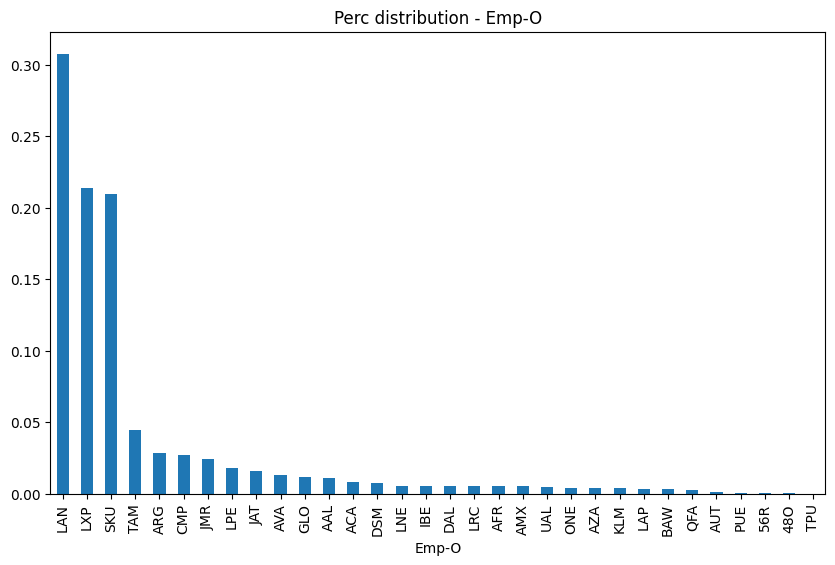

SIGLAORI


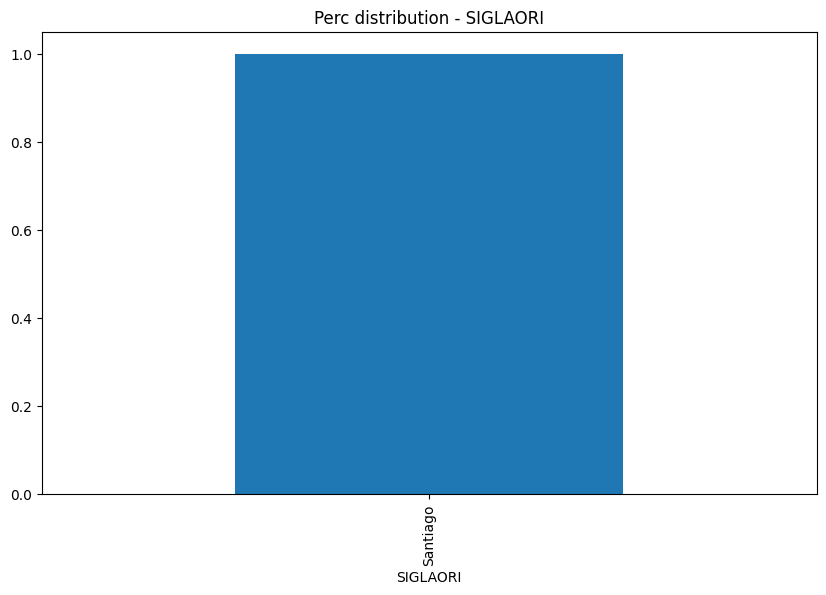

OPERA


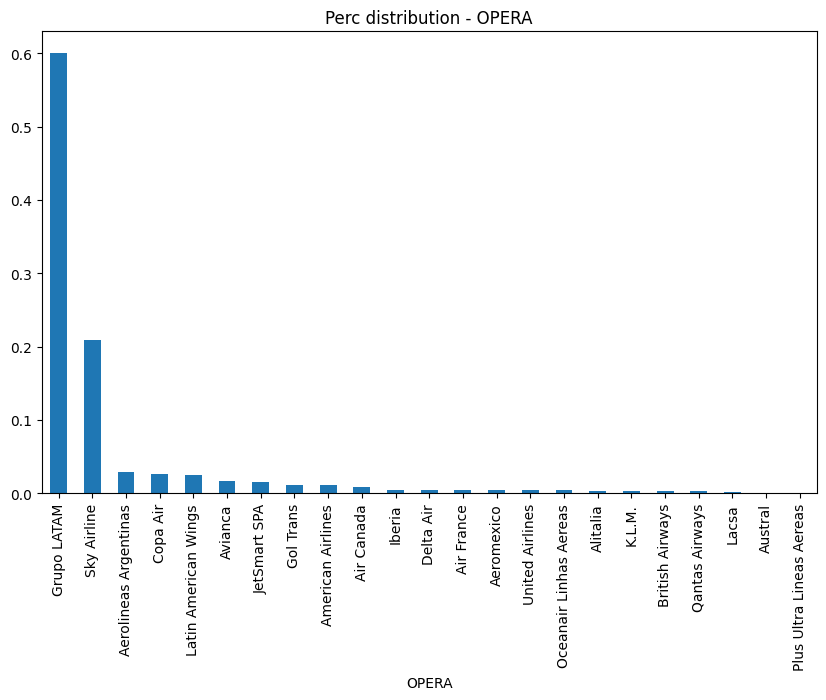

SIGLADES


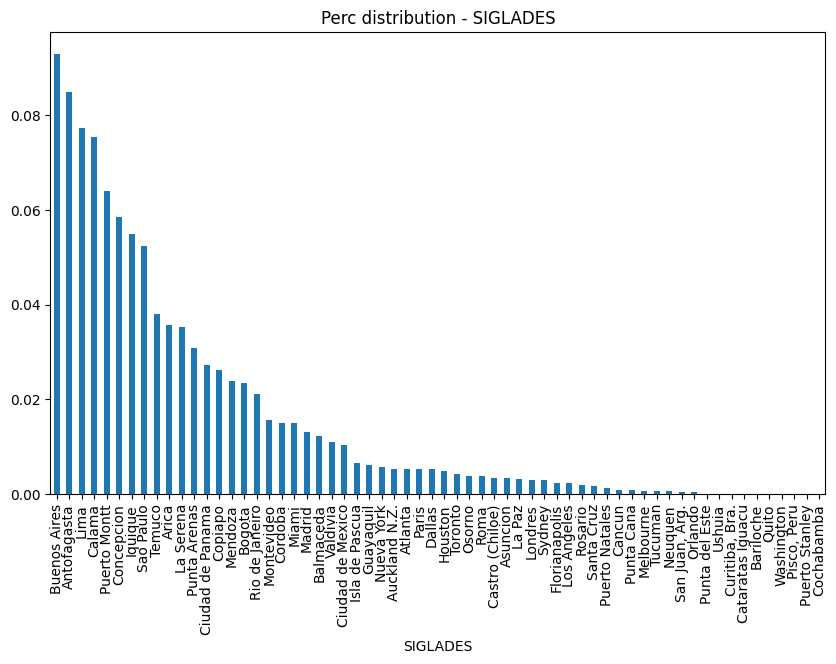

Emp-I


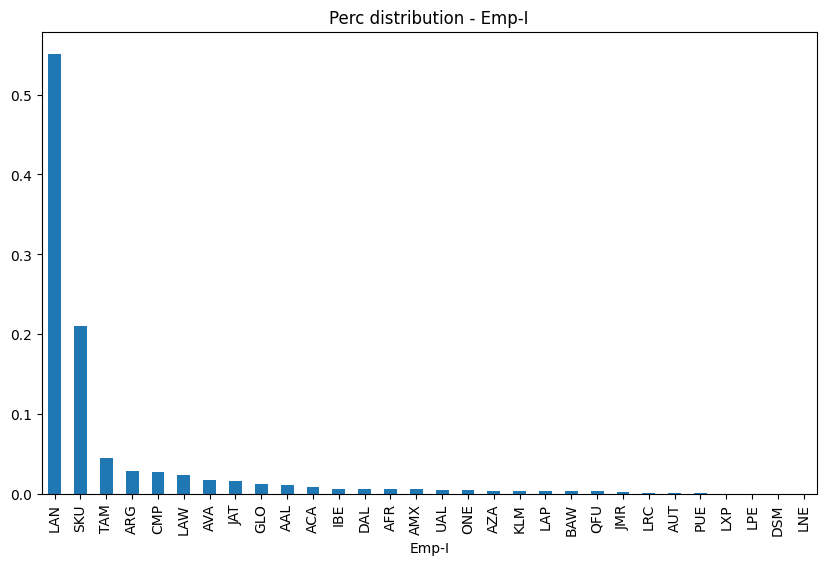

Des-I


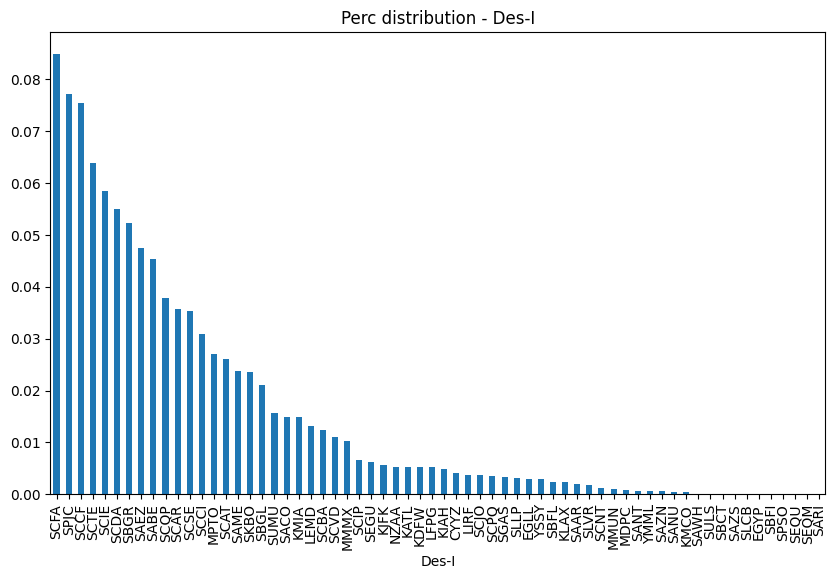

Des-O


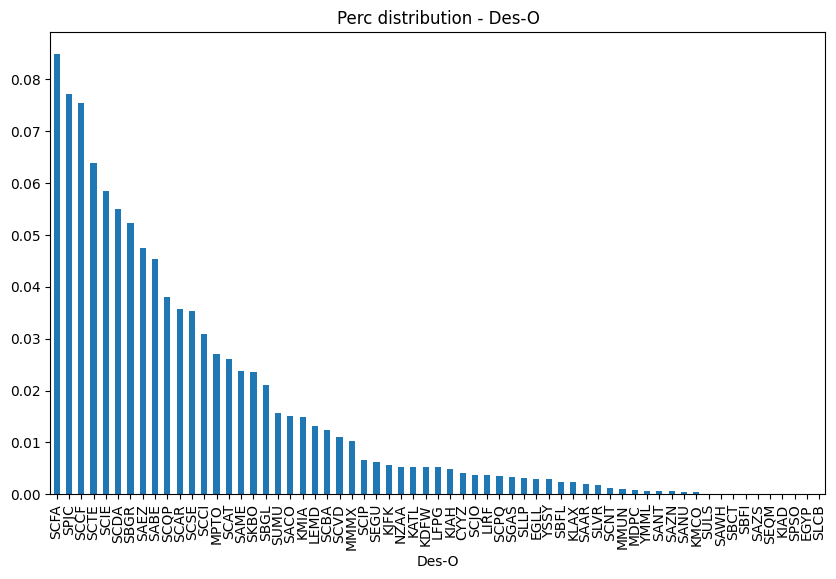

TIPOVUELO


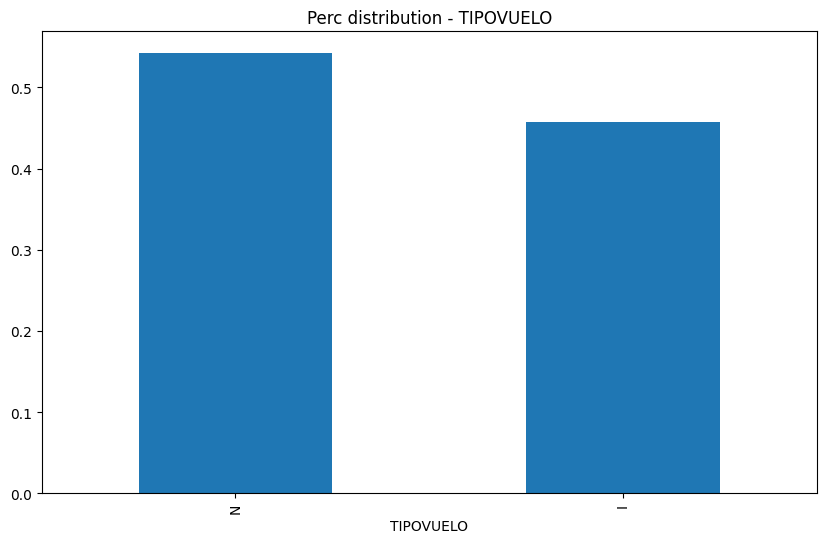

Ori-I


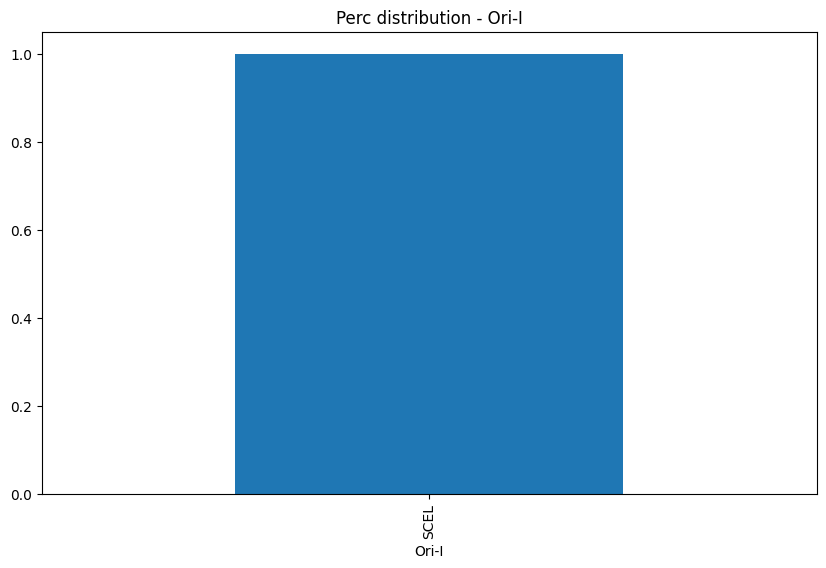

DIANOM


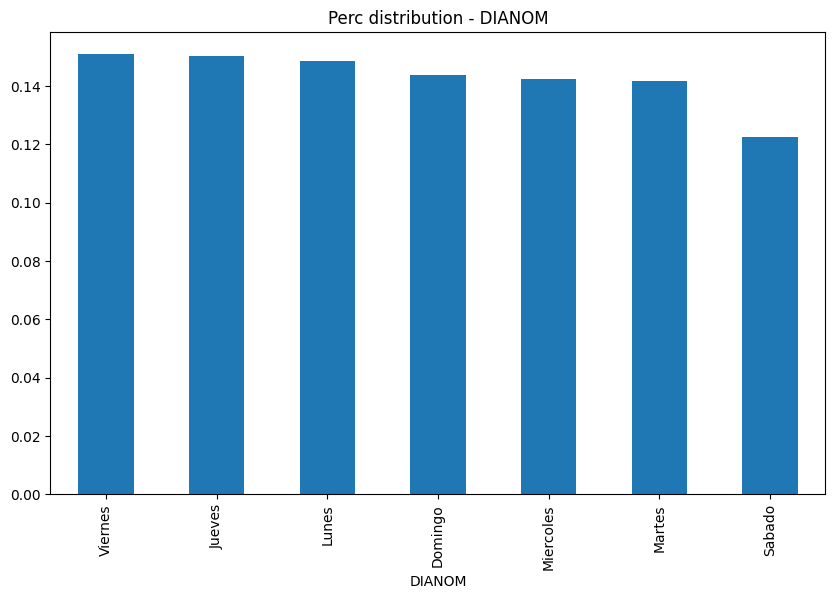

Ori-O


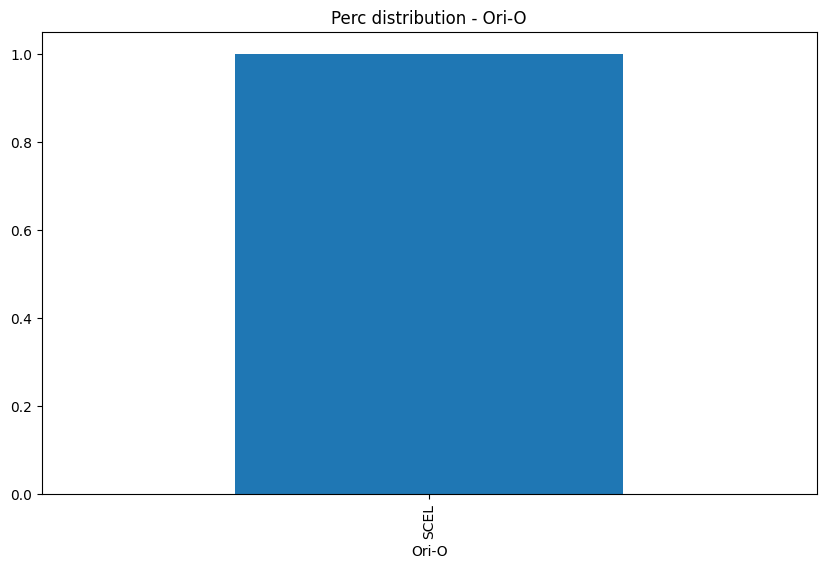

In [16]:
#Plot categorical features
categorical_features = list(df.select_dtypes(include=["object"]).columns)
date_features = ['Fecha-I', 'Fecha-O']
categorical_features = list(set(categorical_features) - set(date_features))

for col in categorical_features:
    print(col)
    plot_bar_categorical_features(df, col)

Translation week days English - Spanish

- Monday – lunes
- Tuesday – martes
- Wednesday – miércoles
- Thursday – jueves
- Friday – viernes
- Saturday – sábado
- Sunday – domingo

### 3.2) Generate the following additional columns. Please export them to a CSV file named synthetic_features.csv:
- high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
- min_diff : difference in minutes between Date-O and Date-I .
- delay_15 : 1 if min_diff > 15, 0 if not.
- period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based
onDate-I .

**Answer:**
- The csv file with the new features were saved inside the folder dataset in this repo

In [17]:
# Convert columns with date information to date type

#Fecha-I: Scheduled date and time of the flight.
#Fecha-O : Date and time of flight operation.
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])

In [18]:
def check_date_between_period(date, start_date, end_date):
    '''Given an hour of the day, this function returns the period of the day'''

    # Define datetime format
    datetime_format = '%Y-%m-%d %H:%M:%S'
    # Define the two times for comparison
    start_date = datetime.strptime(start_date, datetime_format)
    end_date = datetime.strptime(end_date, datetime_format)
    # Check if the data variable is between the start_time and end_time
    is_between_times = start_date <= date <= end_date

    return is_between_times

def categorize_high_season(date):
    '''Given an hour of the day, this function returns the period of the day'''
    
    if check_date_between_period(date, '2017-12-15 00:00:00', '2017-12-31 23:59:59'):
        return 1
    elif check_date_between_period(date, '2017-01-01 00:00:00', '2017-03-03 23:59:59'):
        return 1
    elif check_date_between_period(date, '2017-07-15 00:00:00', '2017-07-31 23:59:59'):
        return 1
    elif check_date_between_period(date, '2017-09-11 00:00:00','2017-09-30 23:59:59'):
        return 1
    else:
        return 0



In [19]:
# Calculate high_season
df['high_season'] = df['Fecha-I'].apply(categorize_high_season)
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,1
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,1
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,1
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,1


In [20]:
def check_time_between_period(date, start_time, end_time):
    '''Given an hour of the day, this function returns the period of the day'''

    # Define datetime format
    datetime_format = '%Y-%m-%d %H:%M:%S'
    # Define the two times for comparison
    start_time = datetime.strptime(date.strftime('%Y-%m-%d')+' '+start_time, datetime_format)
    end_time = datetime.strptime(date.strftime('%Y-%m-%d')+' '+end_time, datetime_format)
    
    # Check if the data variable is between the start_time and end_time
    is_between_times = start_time <= date <= end_time

    return is_between_times

def categorize_period_day(date):
    '''Given an hour of the day, this function returns the period of the day'''
    
    if check_time_between_period(date, '05:00:00', '11:59:00'): 
        return 'morning'
    elif check_time_between_period(date, '12:00:00', '18:59:00'):
        return 'afternoon'
    elif check_time_between_period(date, '19:00:00', '23:59:00') or check_time_between_period(date, '00:00:00', '04:59:00'):
        return 'night'
    else:
        return 'whatever'
    

#print(categorize_period_day(df['Fecha-I'][1549]))
#print(categorize_period_day(df['Fecha-I'][4549]))
#print(categorize_period_day(df['Fecha-I'][7790]))
#print(categorize_period_day(df['Fecha-I'][0]))

In [21]:
#Calculate min_diff
df['min_diff'] = (df['Fecha-O'] - df['Fecha-I']).dt.total_seconds() / 60
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0


In [22]:
#Calculate delay_15
df['delay_15'] = df['min_diff'].apply(lambda x: 1 if x>15 else 0)
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff,delay_15
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,1,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,1,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,1,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,1,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0,0
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,1,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0,0


In [23]:
# Calculate period_day
df['period_day'] = df['Fecha-I'].apply(categorize_period_day)
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0,night
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0,0,night
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0,0,night


In [24]:
df.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'high_season', 'min_diff', 'delay_15',
       'period_day'],
      dtype='object')

In [26]:
#Save updated dataframe with new features as a csv
df.to_csv("dataset/synthetic_features.csv", index=False)

**Visualization of new features**

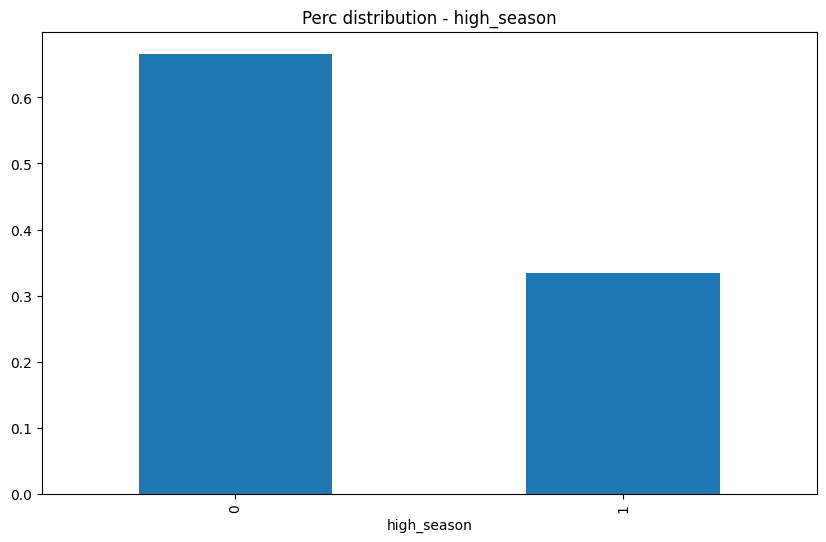

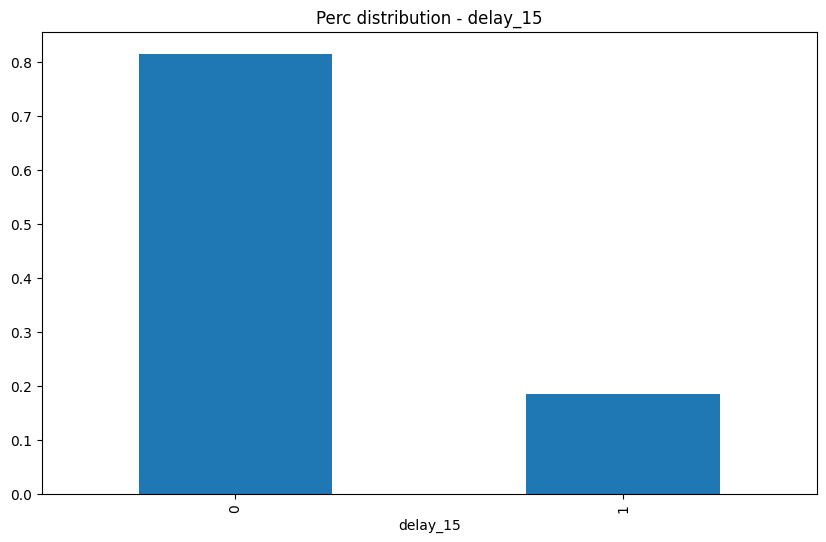

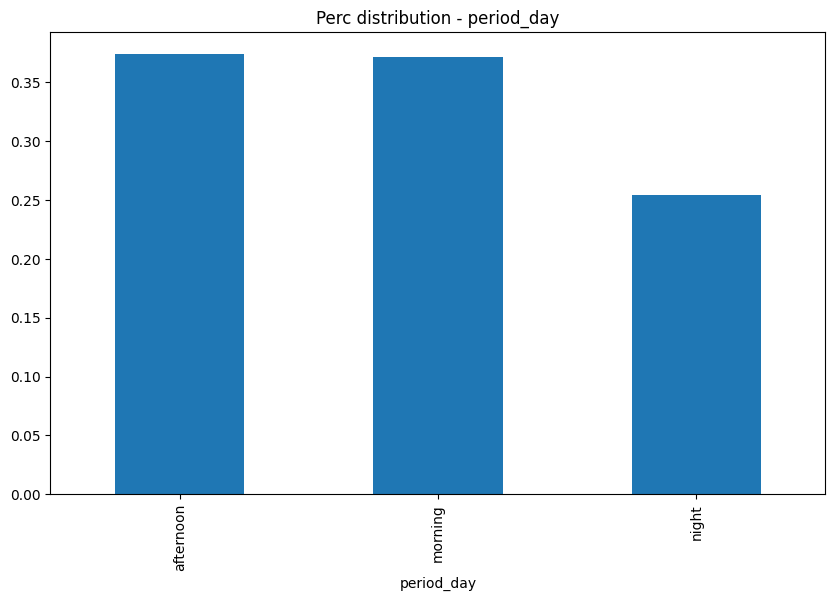

In [28]:

bar_plot_new_features = ['high_season', 'delay_15', 'period_day']
for column_name in bar_plot_new_features:
    plot_bar_categorical_features(df,column_name)

<Axes: >

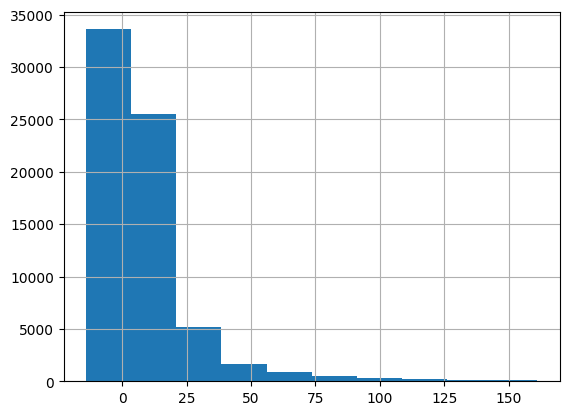

In [29]:
df['min_diff'].hist()

**Insights from new features**
- Long delays are rare; most of the flight delays are around 20 min;
- Most of the time the flight is online or even earlier;
- There are last flights at night;
- The number of flights in the morning and in the afternoon are very similar;
- 20% of the flights delays more than 15 min;
- Around 65% of the flights happens out of high season months.

### 3.3) What is the behavior of the delay rate across destination, airline, month of the year, day of the week, season, type of flight? What variables would you expect to have the most influence in predicting delays?

In [62]:
def plot_stacked_barplot(x, y):
    # Group the DataFrame by the 'weekdays' column and calculate the percentage of delays (1 or 0) in each group
    grouped_data = df.groupby(y)[x].value_counts(normalize=True).unstack().fillna(0)
    grouped_data = grouped_data.sort_values(y, ascending=False)
    #grouped_data = df.groupby('DIANOM')['delay_15'].value_counts(normalize=True).unstack().fillna(0)

    # Plot the grouped bar plot with normalized values
    grouped_data.plot(kind='bar', stacked=True)
    plt.xlabel(y)
    plt.ylabel('Percentage of Delays')
    #plt.title('Percentage of Delays (1 or 0) per Weekday')
    plt.title('Percentage of Delays (1 or 0) per '+y)
    plt.legend(title='Delay', labels=['No Delay (0)', 'Delay (1)'], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.gca().yaxis.set_major_formatter('{:.0%}'.format)  # Format y-axis as percentage
    plt.show()

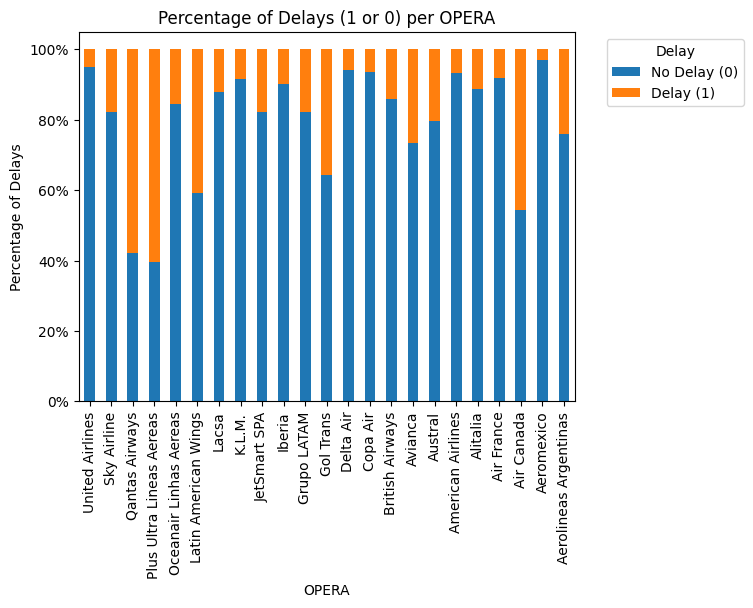

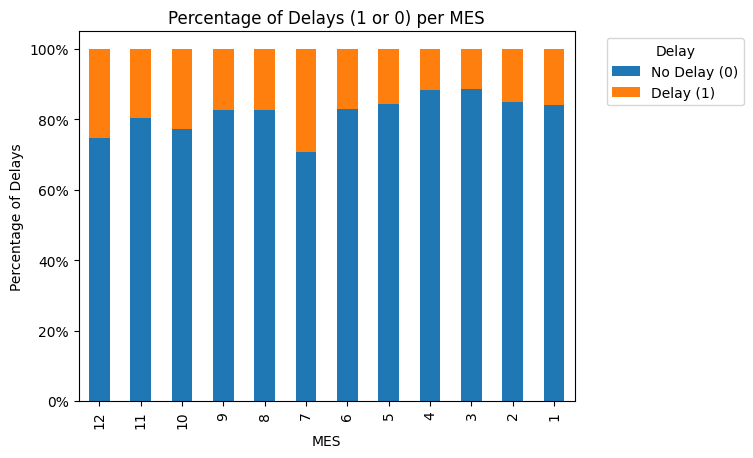

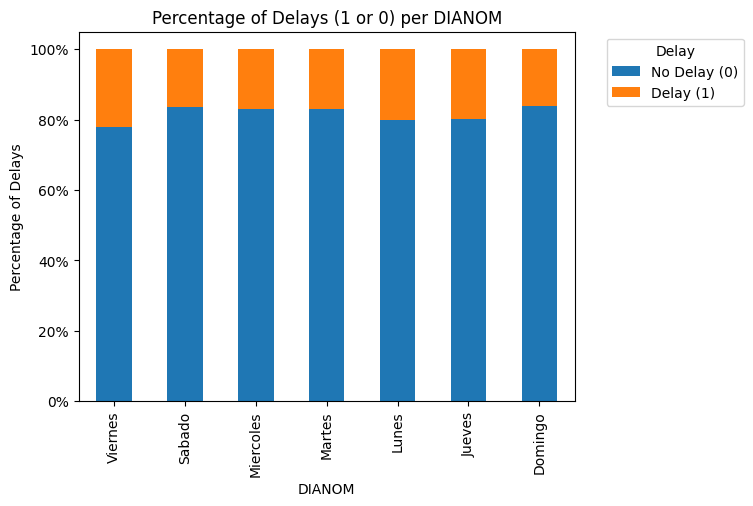

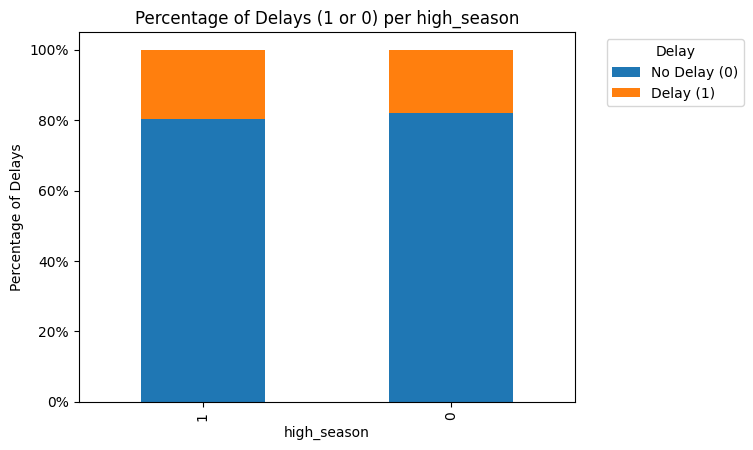

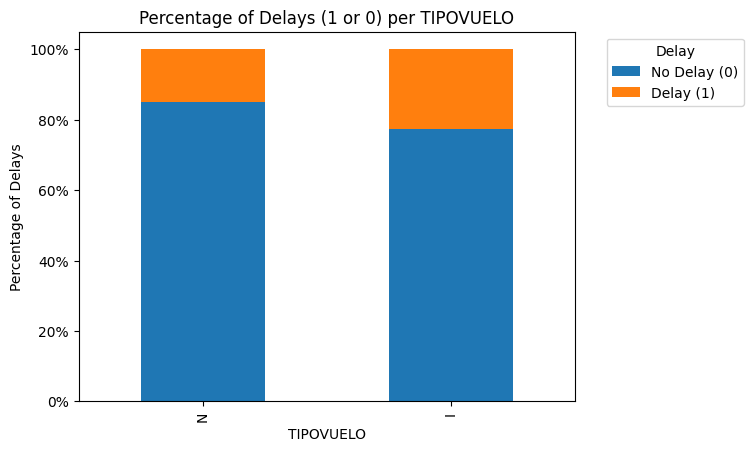

In [63]:
#Plot features with percentage of delays
data_label = 'delay_15'
features_for_analysis = ['OPERA', 'MES', 'DIANOM', 'high_season', 'TIPOVUELO']
for feature in features_for_analysis:
    plot_stacked_barplot(data_label, feature)

### 3.4) Train one or several models (using the algorithm(s) of your choice) to estimate the likelihood of a flight delay. Feel free to generate additional variables and/or supplement with external variables.

### 3.5) Evaluate model performance in the predictive task across each model that you trained. Define and justify what metrics you used to assess model performance. Pick the best trained model and evaluate the following: What variables were the most influential in the prediction task? How could you improve the Performance?